#### ENEM 2016 - Predict the math score of Brazilian National Examination (Undergraduate Students)


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

In [4]:
%matplotlib inline
from IPython.core.pylabtools import figsize
figsize(12, 8)
sns.set()

try:
    sklearn.set_config(display='diagram')
except:
    pass

#### Importing data

In [5]:
training = pd.read_csv("train.csv", nrows = 0, index_col = 0)
print('O número de features presentes no train.set :', training.shape[1])

O número de features presentes no train.set : 166


In [6]:
test = pd.read_csv("test.csv")
print('O número de features presentes no test.set :', test.shape[1])

O número de features presentes no test.set : 47


### EDA

There are more features in traning set tan  test set. So we are going to import the features from test data

In [7]:
cols = test.columns.tolist()
cols.append('NU_NOTA_MT')
cols

['NU_INSCRICAO',
 'CO_UF_RESIDENCIA',
 'SG_UF_RESIDENCIA',
 'NU_IDADE',
 'TP_SEXO',
 'TP_COR_RACA',
 'TP_NACIONALIDADE',
 'TP_ST_CONCLUSAO',
 'TP_ANO_CONCLUIU',
 'TP_ESCOLA',
 'TP_ENSINO',
 'IN_TREINEIRO',
 'TP_DEPENDENCIA_ADM_ESC',
 'IN_BAIXA_VISAO',
 'IN_CEGUEIRA',
 'IN_SURDEZ',
 'IN_DISLEXIA',
 'IN_DISCALCULIA',
 'IN_SABATISTA',
 'IN_GESTANTE',
 'IN_IDOSO',
 'TP_PRESENCA_CN',
 'TP_PRESENCA_CH',
 'TP_PRESENCA_LC',
 'CO_PROVA_CN',
 'CO_PROVA_CH',
 'CO_PROVA_LC',
 'CO_PROVA_MT',
 'NU_NOTA_CN',
 'NU_NOTA_CH',
 'NU_NOTA_LC',
 'TP_LINGUA',
 'TP_STATUS_REDACAO',
 'NU_NOTA_COMP1',
 'NU_NOTA_COMP2',
 'NU_NOTA_COMP3',
 'NU_NOTA_COMP4',
 'NU_NOTA_COMP5',
 'NU_NOTA_REDACAO',
 'Q001',
 'Q002',
 'Q006',
 'Q024',
 'Q025',
 'Q026',
 'Q027',
 'Q047',
 'NU_NOTA_MT']

In [8]:
training = pd.read_csv("train.csv", usecols = cols)
training.sample(5).T

,9410,11182,11905,5591,8627
NU_INSCRICAO,dbfead4e6077e9c9351f0773408b2784c4446989,681a57c94a9004b029b31d40d171fc9269182c1f,f762a9c2eb8fe4d7a16204ce7afaafa2aa49fba5,fb81313eb58c6ae3fcafe75798161a6199f4c292,65d33123ca26415a6de5e89af4a0fbb2fafd2bae
CO_UF_RESIDENCIA,35,53,52,29,42
SG_UF_RESIDENCIA,SP,DF,GO,BA,SC
NU_IDADE,24,17,18,19,17
TP_SEXO,F,F,M,F,F
TP_COR_RACA,1,2,3,3,1
TP_NACIONALIDADE,1,1,1,1,1
TP_ST_CONCLUSAO,1,3,3,1,2
TP_ANO_CONCLUIU,7,0,0,2,0
TP_ESCOLA,1,1,1,1,2


#### From this point, we are going to work on training set only. We'll get back to test set after a while :)

#### Pre-processing (missing data)

In [9]:
completude = pd.DataFrame({
        'colunas' : training.columns,
        'tipo'    : training.dtypes,
        'missing' : training.isna().sum(),
        'size'    : training.shape[0],
        'unicos'  : training.nunique()
})

completude['percentual'] = round(completude['missing'] / completude['size'], 2)

In [10]:
completude.sample(48)

,colunas,tipo,missing,size,unicos,percentual
NU_NOTA_COMP4,NU_NOTA_COMP4,float64,3597,13730,14,0.26
TP_SEXO,TP_SEXO,object,0,13730,2,0.00
TP_ANO_CONCLUIU,TP_ANO_CONCLUIU,int64,0,13730,11,0.00
CO_PROVA_MT,CO_PROVA_MT,object,0,13730,9,0.00
IN_TREINEIRO,IN_TREINEIRO,int64,0,13730,2,0.00
TP_COR_RACA,TP_COR_RACA,int64,0,13730,6,0.00
IN_IDOSO,IN_IDOSO,int64,0,13730,2,0.00
IN_DISCALCULIA,IN_DISCALCULIA,int64,0,13730,2,0.00
NU_IDADE,NU_IDADE,int64,0,13730,55,0.00
Q001,Q001,object,0,13730,8,0.00


### Dropping features without usefull information

In [11]:
training.drop(['NU_INSCRICAO'], axis = 1, inplace = True)

In [12]:
training.shape

(13730, 47)

Dropping null values...

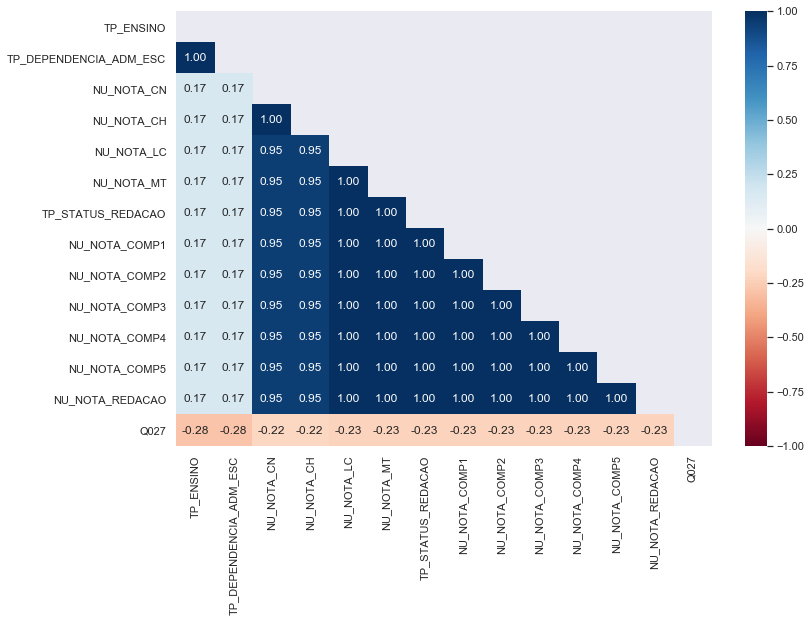

In [13]:
corr = training.isna().corr()
cols = corr.columns[corr.count()>0]
corr = corr.loc[cols, cols]
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask=mask, cmap = 'RdBu', annot = True, vmin = -1, vmax=1, \
            fmt = '.2f')

In [14]:
train = training.copy()
# Simplesmente dropando toda a linha aonde a variável target tem valor NaN na coluna 'NU_NOTA_MT'
training.dropna(subset = ['NU_NOTA_MT'], axis = 0, inplace = True)

# resetando o index, porque algumas linhas foram descartadas
training.reset_index(drop = True, inplace = True)

In [15]:
training.sample(5)

,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,...,NU_NOTA_COMP5,NU_NOTA_REDACAO,Q001,Q002,Q006,Q024,Q025,Q026,Q027,Q047
2555,15,PA,19,M,3,1,1,1,1,NaN,...,120.0,620.0,D,E,C,A,A,A,NaN,A
2746,21,MA,22,M,3,1,1,4,1,NaN,...,40.0,520.0,C,E,B,B,B,B,F,A
3711,51,MT,16,M,1,1,3,0,1,NaN,...,100.0,580.0,A,E,B,B,B,A,NaN,E
499,12,AC,17,M,3,1,1,1,1,NaN,...,80.0,560.0,H,E,B,B,B,A,NaN,A
7233,31,MG,18,M,2,1,1,1,1,NaN,...,60.0,600.0,D,D,C,A,B,A,NaN,A


In [16]:
completude = pd.DataFrame({
        'colunas' : training.columns,
        'tipo'    : training.dtypes,
        'missing' : training.isna().sum(),
        'size'    : training.shape[0],
        'unicos'  : training.nunique()
})

completude['percentual'] = round(completude['missing'] / completude['size'], 2)

In [17]:
completude.head(47)

,colunas,tipo,missing,size,unicos,percentual
CO_UF_RESIDENCIA,CO_UF_RESIDENCIA,int64,0,10133,27,0.00
SG_UF_RESIDENCIA,SG_UF_RESIDENCIA,object,0,10133,27,0.00
NU_IDADE,NU_IDADE,int64,0,10133,53,0.00
TP_SEXO,TP_SEXO,object,0,10133,2,0.00
TP_COR_RACA,TP_COR_RACA,int64,0,10133,6,0.00
TP_NACIONALIDADE,TP_NACIONALIDADE,int64,0,10133,5,0.00
TP_ST_CONCLUSAO,TP_ST_CONCLUSAO,int64,0,10133,4,0.00
TP_ANO_CONCLUIU,TP_ANO_CONCLUIU,int64,0,10133,11,0.00
TP_ESCOLA,TP_ESCOLA,int64,0,10133,4,0.00
TP_ENSINO,TP_ENSINO,float64,6494,10133,3,0.64


In [18]:
print('Colunas que serão descartadas por terem muitos dados faltantes \n', completude[completude['percentual'] > 0.50]['colunas'])

Colunas que serão descartadas por terem muitos dados faltantes 
 TP_ENSINO                              TP_ENSINO
TP_DEPENDENCIA_ADM_ESC    TP_DEPENDENCIA_ADM_ESC
Q027                                        Q027
Name: colunas, dtype: object


In [19]:
training.drop(['TP_ENSINO', 'TP_DEPENDENCIA_ADM_ESC', 'Q027'], axis = 1,\
              inplace = True)

In [20]:
completude = pd.DataFrame({
        'colunas' : training.columns,
        'tipo'    : training.dtypes,
        'missing' : training.isna().sum(),
        'size'    : training.shape[0],
        'unicos'  : training.nunique()
})

completude['percentual'] = round(completude['missing'] / completude['size'], 2)
completude.head(44)

,colunas,tipo,missing,size,unicos,percentual
CO_UF_RESIDENCIA,CO_UF_RESIDENCIA,int64,0,10133,27,0.0
SG_UF_RESIDENCIA,SG_UF_RESIDENCIA,object,0,10133,27,0.0
NU_IDADE,NU_IDADE,int64,0,10133,53,0.0
TP_SEXO,TP_SEXO,object,0,10133,2,0.0
TP_COR_RACA,TP_COR_RACA,int64,0,10133,6,0.0
TP_NACIONALIDADE,TP_NACIONALIDADE,int64,0,10133,5,0.0
TP_ST_CONCLUSAO,TP_ST_CONCLUSAO,int64,0,10133,4,0.0
TP_ANO_CONCLUIU,TP_ANO_CONCLUIU,int64,0,10133,11,0.0
TP_ESCOLA,TP_ESCOLA,int64,0,10133,4,0.0
IN_TREINEIRO,IN_TREINEIRO,int64,0,10133,2,0.0


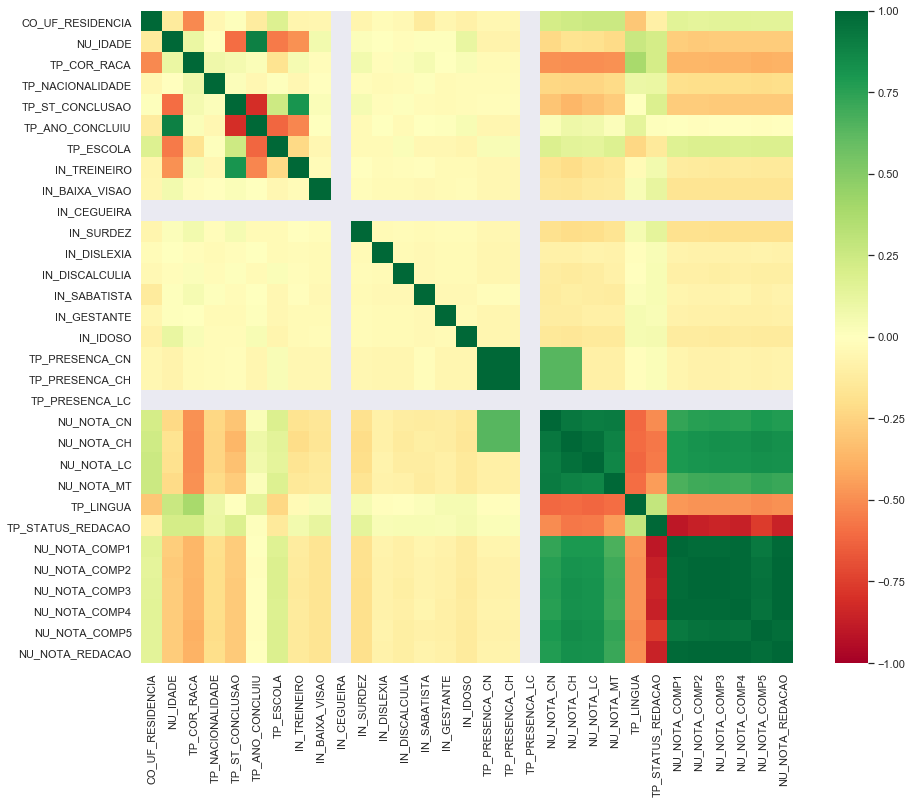

In [21]:
cor_matrix = training.corr()
fig, ax = plt.subplots(figsize = (15, 12))
sns.heatmap(cor_matrix.corr(), square = True, cmap = 'RdYlGn', vmin = -1, \
            vmax=1, fmt = '.2f',ax = ax)
plt.show()
plt.close()

In [22]:
# Numerical features
training_num = training.select_dtypes(include = [np.number])
num_list = training_num.columns.tolist()
num_list.remove('NU_NOTA_MT')
print('As features numericas que serão usadas no modelo 1:\n', num_list)

As features numericas que serão usadas no modelo 1:
 ['CO_UF_RESIDENCIA', 'NU_IDADE', 'TP_COR_RACA', 'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO', 'TP_ANO_CONCLUIU', 'TP_ESCOLA', 'IN_TREINEIRO', 'IN_BAIXA_VISAO', 'IN_CEGUEIRA', 'IN_SURDEZ', 'IN_DISLEXIA', 'IN_DISCALCULIA', 'IN_SABATISTA', 'IN_GESTANTE', 'IN_IDOSO', 'TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_LC', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'TP_LINGUA', 'TP_STATUS_REDACAO', 'NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4', 'NU_NOTA_COMP5', 'NU_NOTA_REDACAO']


In [23]:
X = training_num.drop('NU_NOTA_MT', axis = 1)
y = training_num['NU_NOTA_MT']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [24]:
num_tr= Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors = 3, weights = 'uniform')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(transformers =[
    ('num', num_tr, num_list),
])


model1 = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('linear_model', LinearRegression())
])

In [25]:
model1.fit(X_train, y_train)
train_score = model1.score(X_train, y_train)
print('Training_score: ', train_score)

y_preds = model1.predict(X_test)
# Compute and print r2 and RMSE

print('Testing score: {}'.format(r2_score(y_test, y_preds)))
print('MAE:', mean_absolute_error(y_test, y_preds))

rmse = np.sqrt(mean_squared_error(y_test, y_preds))
print('Root Mean Squared Error: {}'.format(rmse))

Training_score:  0.41648291808428844
Testing score: -23278842301125.082
MAE: 10575088.105710767
Root Mean Squared Error: 476111152.4854079


In [26]:
y_preds = model1.predict(test)
answer = pd.DataFrame({
    'NU_INSCRICAO'  :   test['NU_INSCRICAO'],
    'NU_NOTA_MT'    :   y_preds
})
answer.sample(10)

,NU_INSCRICAO,NU_NOTA_MT
2772,387e9fa8f1278ffb136f52b79a2ebb4eab6d2c48,4.308883e+02
116,66cf0f8b5af2466f9616fd15c0c10344df84982a,-3.948616e+08
2069,6131a9bdf2d85c90d320ad0494a4d58c67dbe290,-3.948617e+08
2513,52feee56c52b89353482d8ff79596da74721397d,4.624665e+02
1506,e65ba317385a51e76379f53a718b43678d468a17,4.886076e+02
1168,dbeac2f05498472ec708163898309999efef03f2,3.799821e+02
3351,4edca8199f784e18664ecdaee73a20978df1ed4d,-3.948618e+08
673,a6fec1f8773ba19000f5a316d4bc0cacf1a3ad51,6.436996e+02
4036,9eab7eef302e43a59349cce16bf13ec56b5b1650,4.250257e+02
1280,67da0b704f0c6cc6037509ab516aaaf58fd950b0,4.756639e+02


In [27]:
corr_matrix = training_num.corr()
corr_matrix['NU_NOTA_MT'].sort_values(ascending = False)

NU_NOTA_MT           1.000000
NU_NOTA_CN           0.584941
NU_NOTA_CH           0.529594
NU_NOTA_LC           0.494695
NU_NOTA_REDACAO      0.379376
NU_NOTA_COMP3        0.350307
NU_NOTA_COMP5        0.343337
NU_NOTA_COMP4        0.342282
NU_NOTA_COMP2        0.335638
NU_NOTA_COMP1        0.299402
CO_UF_RESIDENCIA     0.107493
TP_ESCOLA            0.069304
TP_ANO_CONCLUIU      0.029039
IN_DISCALCULIA       0.009813
TP_PRESENCA_CH       0.003552
TP_PRESENCA_CN       0.003552
IN_DISLEXIA          0.001453
IN_BAIXA_VISAO       0.000685
IN_GESTANTE         -0.000945
IN_IDOSO            -0.011336
IN_SURDEZ           -0.015249
IN_SABATISTA        -0.016459
IN_TREINEIRO        -0.022287
TP_NACIONALIDADE    -0.034965
TP_STATUS_REDACAO   -0.059376
NU_IDADE            -0.061485
TP_ST_CONCLUSAO     -0.087869
TP_COR_RACA         -0.157364
TP_LINGUA           -0.201726
IN_CEGUEIRA               NaN
TP_PRESENCA_LC            NaN
Name: NU_NOTA_MT, dtype: float64

In [28]:
training_2 = training[['NU_NOTA_MT', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC',\
                      'NU_NOTA_REDACAO', 'NU_NOTA_COMP5', 'NU_NOTA_COMP4',\
                      'NU_NOTA_COMP3', 'NU_NOTA_COMP2', 'NU_NOTA_COMP1']]
training_2.describe().T

,count,mean,std,min,25%,50%,75%,max
NU_NOTA_MT,10133.0,482.497928,99.826323,0.0,408.9,461.2,537.6,952.0
NU_NOTA_CN,10097.0,473.912509,71.098468,0.0,420.1,460.4,515.1,806.4
NU_NOTA_CH,10097.0,530.346123,73.528309,0.0,481.0,532.6,581.9,807.0
NU_NOTA_LC,10133.0,516.472841,68.688190,0.0,468.1,520.9,564.9,763.6
NU_NOTA_REDACAO,10133.0,529.048258,154.294758,0.0,440.0,540.0,600.0,1000.0
NU_NOTA_COMP5,10133.0,77.372446,43.067140,0.0,40.0,80.0,100.0,200.0
NU_NOTA_COMP4,10133.0,113.123951,33.480033,0.0,100.0,120.0,120.0,200.0
NU_NOTA_COMP3,10133.0,106.824238,34.341349,0.0,80.0,120.0,120.0,200.0
NU_NOTA_COMP2,10133.0,111.915918,33.737588,0.0,100.0,120.0,120.0,200.0
NU_NOTA_COMP1,10133.0,119.811704,29.846017,0.0,120.0,120.0,140.0,200.0


In [29]:
num_list = training_2.columns.tolist()
num_list.remove('NU_NOTA_MT')
print('As features numericas que serão usadas no modelo 1:\n', num_list)

As features numericas que serão usadas no modelo 1:
 ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_REDACAO', 'NU_NOTA_COMP5', 'NU_NOTA_COMP4', 'NU_NOTA_COMP3', 'NU_NOTA_COMP2', 'NU_NOTA_COMP1']


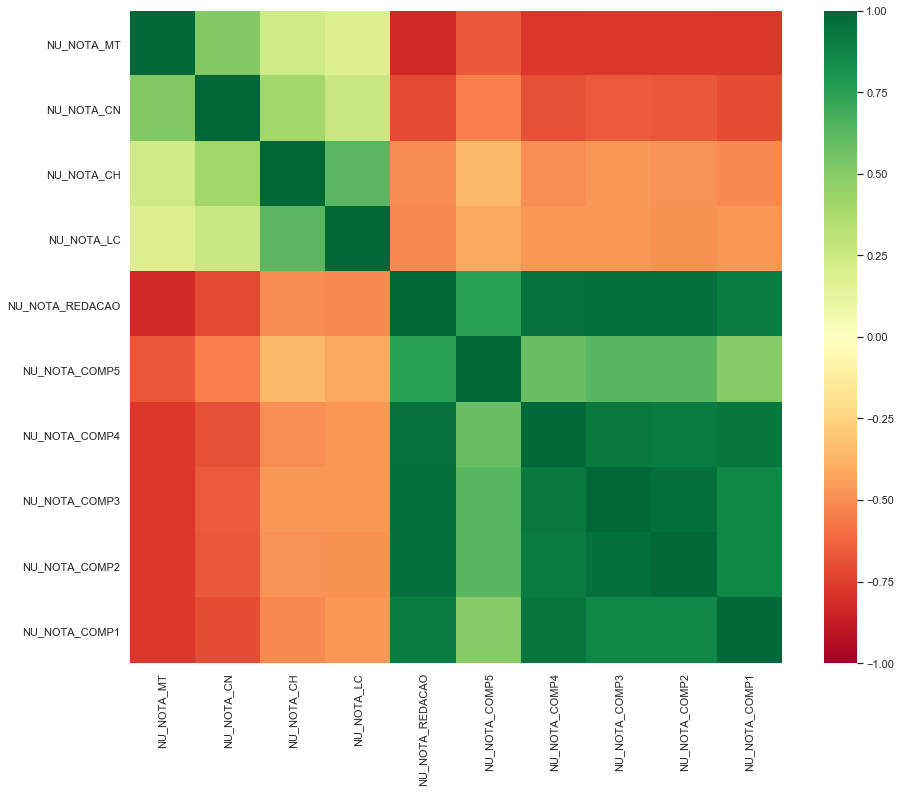

In [30]:
corr_matrix = training_2.corr()
fig, ax = plt.subplots(figsize = (15, 12))
sns.heatmap(corr_matrix.corr(), square = True, cmap = 'RdYlGn', vmin = -1, \
            vmax=1, fmt = '.2f',ax = ax)
plt.show()
plt.close()

In [31]:
X = training_2.drop('NU_NOTA_MT', axis = 1)
y = training_2['NU_NOTA_MT']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [32]:
num_tr= Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors = 3, weights = 'uniform')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(transformers =[
    ('num', num_tr, num_list),
])


model2 = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('linear_model', LinearRegression())
])

In [33]:
model2.fit(X_train, y_train)
train_score = model2.score(X_train, y_train)
print('Training score - R2: ', train_score)

y_preds = model2.predict(X_test)
# Compute and print r2 and RMSE

print('Testing score - R2: {}'.format(r2_score(y_test, y_preds)))
print('MAE:', mean_absolute_error(y_test, y_preds))

rmse = np.sqrt(mean_squared_error(y_test, y_preds))
print('RMSE: {}'.format(rmse))

Training score - R2:  0.4091712575040053
Testing score - R2: 0.368812045746701
MAE: 61.62004316211614
RMSE: 78.39836697130329


In [34]:
y_preds = model2.predict(test)
answer = pd.DataFrame({
    'NU_INSCRICAO'  :   test['NU_INSCRICAO'],
    'NU_NOTA_MT'    :   y_preds
})
answer.sample(10)

,NU_INSCRICAO,NU_NOTA_MT
4293,9982a7bff95da5b87427ba4c1d2893de4bee0ce6,482.963165
3354,73db67467281416a1204cf2bab8bf48c766ee542,557.885271
1930,3b7a6b21c4c3e725ebf18a0e0cb24c7b927fb1c0,482.963165
820,e1b13253d0c6d128395ef9038e81b867ccffd75d,482.963165
1125,e4e972daa04fa516a7faddc8f3a9051fa1a3ef73,442.873844
137,829dd51f77f3ae74c2216de2d86139bd0a03367c,482.963165
71,dbaa6ee7502cbebb6f058fed5d2f960b19f451ac,425.784750
3052,278f1ed100593c6f2109f12ea72ad32db84f1d82,407.951383
1601,6b1f9719f4ec4a7fe616add935a05001a7983f42,482.963165
3613,e132dc710bf40da1b4e565d1ee233c1bd0ada1ae,482.963165


In [35]:
answer.to_csv('answer.csv', index = False)

In [36]:
training_3 = training[['NU_NOTA_MT', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC',\
                      'NU_NOTA_REDACAO']]
training_3.describe().T

,count,mean,std,min,25%,50%,75%,max
NU_NOTA_MT,10133.0,482.497928,99.826323,0.0,408.9,461.2,537.6,952.0
NU_NOTA_CN,10097.0,473.912509,71.098468,0.0,420.1,460.4,515.1,806.4
NU_NOTA_CH,10097.0,530.346123,73.528309,0.0,481.0,532.6,581.9,807.0
NU_NOTA_LC,10133.0,516.472841,68.688190,0.0,468.1,520.9,564.9,763.6
NU_NOTA_REDACAO,10133.0,529.048258,154.294758,0.0,440.0,540.0,600.0,1000.0


In [37]:
num_list = training_3.columns.tolist()
num_list.remove('NU_NOTA_MT')
print('As features numericas que serão usadas no modelo 1:\n', num_list)

As features numericas que serão usadas no modelo 1:
 ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_REDACAO']


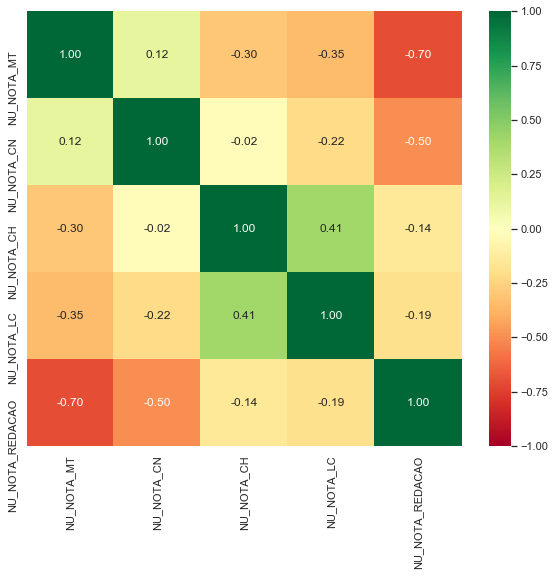

In [38]:
corr_matrix = training_3.corr()
fig, ax = plt.subplots(figsize = (10, 8))
sns.heatmap(corr_matrix.corr(), square = True, cmap = 'RdYlGn', vmin = -1, \
            vmax=1, fmt = '.2f',annot = True,ax = ax)
plt.show()
plt.close()

In [39]:
X = training_3.drop('NU_NOTA_MT', axis = 1)
y = training_3['NU_NOTA_MT']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [40]:
num_tr= Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors = 3, weights = 'uniform')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(transformers =[
    ('num', num_tr, num_list),
])


model3 = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('linear_model', LinearRegression())
])

In [41]:
model3.fit(X_train, y_train)
train_score = model3.score(X_train, y_train)
print('Training score - R2: ', train_score)

y_preds = model3.predict(X_test)
# Compute and print r2 and RMSE

print('Testing score - R2: {}'.format(r2_score(y_test, y_preds)))
print('MAE:', mean_absolute_error(y_test, y_preds))

rmse = np.sqrt(mean_squared_error(y_test, y_preds))
print('RMSE: {}'.format(rmse))

Training score - R2:  0.40791049852074546
Testing score - R2: 0.37315250828467095
MAE: 61.40862406564038
RMSE: 78.12834264752932


In [42]:
y_preds = model2.predict(test)
answer = pd.DataFrame({
    'NU_INSCRICAO'  :   test['NU_INSCRICAO'],
    'NU_NOTA_MT'    :   y_preds
})
answer.sample(10)

,NU_INSCRICAO,NU_NOTA_MT
2725,8d1967edeeea7561710452a89b98f1baffc32a6a,409.621029
1762,61591e4809bbfebc15f6520e549334e1fc6e0d13,495.593092
56,bdca9aeb19521675af15f2c28d86f6bebc45a834,486.438821
813,44c3c8ed6d54ed6c23b5690fd7edc54b7f64804b,471.983930
902,ad1a5a001fb410e949c882c3cefcaf88311f6fa8,423.853268
1611,f2c02571ccffbc71ed989ca6e81ce0a866aca9e6,488.211485
3850,39afaf1c7ac2609fb67d2a82420917b00cf6d8af,454.010450
2980,c54cbdc74a346842b5e2800efaab4e6f768b4bab,446.516689
3153,c0e186cfae2c2a170e142560a50bb3d77e47021c,444.611985
13,9ad714b116da76d878dd399d187fccc2dd13dd63,572.153314


In [43]:
answer.to_csv('answer.csv', index = False)

In [44]:
training_4 = training[['NU_NOTA_CN', 
                       'NU_NOTA_CH', 
                       'NU_NOTA_LC', 
                       'NU_NOTA_REDACAO',
                       'TP_SEXO', 
                       'TP_COR_RACA', 
                       'TP_ST_CONCLUSAO', 
                       'TP_ANO_CONCLUIU',
                       'TP_ESCOLA',  
                       'NU_IDADE',   
                       'TP_STATUS_REDACAO', 
                       'Q001','Q002', 'Q006', 'Q024', 'Q025', 'Q026', 'Q047', 
                       'NU_NOTA_MT', 
                       'NU_NOTA_COMP5', 'NU_NOTA_COMP4', 'NU_NOTA_COMP3', 'NU_NOTA_COMP2', 'NU_NOTA_COMP1']]                       

In [45]:
# Numerical features
training_num = training_4.select_dtypes(include = [np.number])
num_list = training_num.columns.tolist()
num_list.remove('NU_NOTA_MT')
print('As features numericas que serão usadas no modelo 4:\n', num_list)

As features numericas que serão usadas no modelo 4:
 ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_REDACAO', 'TP_COR_RACA', 'TP_ST_CONCLUSAO', 'TP_ANO_CONCLUIU', 'TP_ESCOLA', 'NU_IDADE', 'TP_STATUS_REDACAO', 'NU_NOTA_COMP5', 'NU_NOTA_COMP4', 'NU_NOTA_COMP3', 'NU_NOTA_COMP2', 'NU_NOTA_COMP1']


In [46]:
# categorical features
training_cat = training_4.select_dtypes(include = [np.object])
cat_list = training_cat.columns.tolist()
print('As features categoricas que serão usadas no modelo 4:\n', cat_list)

As features categoricas que serão usadas no modelo 4:
 ['TP_SEXO', 'Q001', 'Q002', 'Q006', 'Q024', 'Q025', 'Q026', 'Q047']


In [47]:
X = training_4.drop('NU_NOTA_MT', axis = 1)
y = training_4['NU_NOTA_MT']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

num_tr= Pipeline(steps = [
    ('imputer', KNNImputer(n_neighbors = 3, weights = 'uniform')),
    ('scaler', StandardScaler())
])

cat_tr = Pipeline(steps = [
    ('one-hot-encoder', OneHotEncoder(sparse = False, handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers =[
    ('num', num_tr, num_list),
    ('cat', cat_tr, cat_list)
])

model4 = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('linear_model', LinearRegression())
])

In [48]:
model4.fit(X_train, y_train)
train_score = model4.score(X_train, y_train)
print('Training score - R2: ', train_score)

y_preds = model4.predict(X_test)
# Compute and print r2 and RMSE

print('Testing score - R2: {}'.format(r2_score(y_test, y_preds)))
print('MAE:', mean_absolute_error(y_test, y_preds))

rmse = np.sqrt(mean_squared_error(y_test, y_preds))
print('RMSE: {}'.format(rmse))

Training score - R2:  0.4571745787334449
Testing score - R2: 0.39644146704922256
MAE: 59.97541394301925
RMSE: 76.66327402663713


In [49]:
y_preds = model4.predict(test)
answer = pd.DataFrame({
    'NU_INSCRICAO'  :   test['NU_INSCRICAO'],
    'NU_NOTA_MT'    :   y_preds
})
answer.sample(10)

,NU_INSCRICAO,NU_NOTA_MT
4331,70b2ac7ae59de6f956386af9c59c9a1897d5a29c,620.812500
224,3671441f51dc0c3d052e87d6b8beba46bb70bfeb,416.617188
3593,537e2b3126d1ac5dbbcfde55d0549dda561b575e,604.375000
3709,f0527e3f10cbf275c69eda7ebf7e521f74723644,490.343750
2459,601bc46879ceda8acc99c9e024bcf5ae418bed93,453.218750
2608,e0046f52481512ec10030f695dd3d56c14963819,550.281250
2124,83797d1bf8140346397218425aef1b72c0976645,493.468750
1958,b74fa1d7ed3e8cc0c74aae5393a0dcbeaccd18bb,472.242188
2367,7a48ae2165b2829894c952ab60838a7af20168e0,489.187500
3527,25649c8b169c66dfc43ff7735ec439eeb4c43cb1,366.078125


In [50]:
answer.to_csv('answer.csv', index = False)

In [51]:
train.sample(5)

,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,...,NU_NOTA_COMP5,NU_NOTA_REDACAO,Q001,Q002,Q006,Q024,Q025,Q026,Q027,Q047
10560,25,PB,26,M,3,1,1,2,1,NaN,...,40.0,500.0,C,C,B,B,A,B,F,A
7426,43,RS,30,F,1,1,1,10,1,NaN,...,NaN,NaN,E,E,G,B,A,C,NaN,A
13521,15,PA,19,M,2,1,4,0,1,NaN,...,80.0,480.0,E,E,C,A,A,A,NaN,A
8423,26,PE,25,F,1,1,4,0,1,NaN,...,NaN,NaN,B,D,C,B,B,B,D,A
7442,23,CE,19,M,4,1,1,1,1,NaN,...,NaN,NaN,E,D,B,A,A,A,NaN,A


In [52]:
completude = pd.DataFrame({
        'colunas' : train.columns,
        'tipo'    : train.dtypes,
        'missing' : train.isna().sum(),
        'size'    : train.shape[0],
        'unicos'  : train.nunique()
})

completude['percentual'] = round(completude['missing'] / completude['size'], 2)
completude.head(47)

,colunas,tipo,missing,size,unicos,percentual
CO_UF_RESIDENCIA,CO_UF_RESIDENCIA,int64,0,13730,27,0.00
SG_UF_RESIDENCIA,SG_UF_RESIDENCIA,object,0,13730,27,0.00
NU_IDADE,NU_IDADE,int64,0,13730,55,0.00
TP_SEXO,TP_SEXO,object,0,13730,2,0.00
TP_COR_RACA,TP_COR_RACA,int64,0,13730,6,0.00
TP_NACIONALIDADE,TP_NACIONALIDADE,int64,0,13730,5,0.00
TP_ST_CONCLUSAO,TP_ST_CONCLUSAO,int64,0,13730,4,0.00
TP_ANO_CONCLUIU,TP_ANO_CONCLUIU,int64,0,13730,11,0.00
TP_ESCOLA,TP_ESCOLA,int64,0,13730,4,0.00
TP_ENSINO,TP_ENSINO,float64,9448,13730,3,0.69


In [53]:
train.drop(['Q027', 'TP_DEPENDENCIA_ADM_ESC', 'TP_ENSINO'], axis = 1, inplace = True)

In [54]:
completude = pd.DataFrame({
        'colunas' : train.columns,
        'tipo'    : train.dtypes,
        'missing' : train.isna().sum(),
        'size'    : train.shape[0],
        'unicos'  : train.nunique()
})

completude['percentual'] = round(completude['missing'] / completude['size'], 2)
completude.head(44)

,colunas,tipo,missing,size,unicos,percentual
CO_UF_RESIDENCIA,CO_UF_RESIDENCIA,int64,0,13730,27,0.00
SG_UF_RESIDENCIA,SG_UF_RESIDENCIA,object,0,13730,27,0.00
NU_IDADE,NU_IDADE,int64,0,13730,55,0.00
TP_SEXO,TP_SEXO,object,0,13730,2,0.00
TP_COR_RACA,TP_COR_RACA,int64,0,13730,6,0.00
TP_NACIONALIDADE,TP_NACIONALIDADE,int64,0,13730,5,0.00
TP_ST_CONCLUSAO,TP_ST_CONCLUSAO,int64,0,13730,4,0.00
TP_ANO_CONCLUIU,TP_ANO_CONCLUIU,int64,0,13730,11,0.00
TP_ESCOLA,TP_ESCOLA,int64,0,13730,4,0.00
IN_TREINEIRO,IN_TREINEIRO,int64,0,13730,2,0.00


In [55]:
# preenchendo as linhas com a nota de matemática NaN, com zero
train.fillna({'NU_NOTA_MT': 0}, inplace = True)

In [56]:
completude = pd.DataFrame({
        'colunas' : train.columns,
        'tipo'    : train.dtypes,
        'missing' : train.isna().sum(),
        'size'    : train.shape[0],
        'unicos'  : train.nunique()
})

completude['percentual'] = round(completude['missing'] / completude['size'], 2)
completude.head(44)

,colunas,tipo,missing,size,unicos,percentual
CO_UF_RESIDENCIA,CO_UF_RESIDENCIA,int64,0,13730,27,0.00
SG_UF_RESIDENCIA,SG_UF_RESIDENCIA,object,0,13730,27,0.00
NU_IDADE,NU_IDADE,int64,0,13730,55,0.00
TP_SEXO,TP_SEXO,object,0,13730,2,0.00
TP_COR_RACA,TP_COR_RACA,int64,0,13730,6,0.00
TP_NACIONALIDADE,TP_NACIONALIDADE,int64,0,13730,5,0.00
TP_ST_CONCLUSAO,TP_ST_CONCLUSAO,int64,0,13730,4,0.00
TP_ANO_CONCLUIU,TP_ANO_CONCLUIU,int64,0,13730,11,0.00
TP_ESCOLA,TP_ESCOLA,int64,0,13730,4,0.00
IN_TREINEIRO,IN_TREINEIRO,int64,0,13730,2,0.00


In [57]:
training_5 = train[['NU_NOTA_CN', 
                       'NU_NOTA_CH', 
                       'NU_NOTA_LC', 
                       'NU_NOTA_REDACAO',
                       'TP_SEXO', 
                       'TP_COR_RACA', 
                       'TP_ST_CONCLUSAO', 
                       'TP_ANO_CONCLUIU',
                       'TP_ESCOLA',  
                       'NU_IDADE',   
                       'TP_STATUS_REDACAO', 
                       'Q001','Q002', 'Q006', 'Q024', 'Q025', 'Q026', 'Q047', 
                       'NU_NOTA_MT', 
                       'NU_NOTA_COMP5', 'NU_NOTA_COMP4', 'NU_NOTA_COMP3', 'NU_NOTA_COMP2', 'NU_NOTA_COMP1']]                       

In [58]:
# Numerical features
training_num = training_5.select_dtypes(include = [np.number])
num_list = training_num.columns.tolist()
num_list.remove('NU_NOTA_MT')
print('As features numericas que serão usadas no modelo 5:\n', num_list)

As features numericas que serão usadas no modelo 5:
 ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_REDACAO', 'TP_COR_RACA', 'TP_ST_CONCLUSAO', 'TP_ANO_CONCLUIU', 'TP_ESCOLA', 'NU_IDADE', 'TP_STATUS_REDACAO', 'NU_NOTA_COMP5', 'NU_NOTA_COMP4', 'NU_NOTA_COMP3', 'NU_NOTA_COMP2', 'NU_NOTA_COMP1']


In [59]:
# categorical features
training_cat = training_4.select_dtypes(include = [np.object])
cat_list = training_cat.columns.tolist()
print('As features categoricas que serão usadas no modelo 5:\n', cat_list)

As features categoricas que serão usadas no modelo 5:
 ['TP_SEXO', 'Q001', 'Q002', 'Q006', 'Q024', 'Q025', 'Q026', 'Q047']


In [60]:
X = training_5.drop('NU_NOTA_MT', axis = 1)
y = training_5['NU_NOTA_MT']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

num_tr= Pipeline(steps = [
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
    ('scaler', StandardScaler())
])

cat_tr = Pipeline(steps = [
    ('one-hot-encoder', OneHotEncoder(sparse = False, handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers =[
    ('num', num_tr, num_list),
    ('cat', cat_tr, cat_list)
])

model5 = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('linear_model', LinearRegression())
])

In [61]:
model5.fit(X_train, y_train)
train_score = model5.score(X_train, y_train)
print('Training score - R2: ', train_score)

y_preds = model5.predict(X_test)
# Compute and print r2 and RMSE

print('Testing score - R2: {}'.format(r2_score(y_test, y_preds)))
print('MAE:', mean_absolute_error(y_test, y_preds))

rmse = np.sqrt(mean_squared_error(y_test, y_preds))
print('RMSE: {}'.format(rmse))

Training score - R2:  0.9193910977764594
Testing score - R2: 0.9221124626671016
MAE: 46.76972983430444
RMSE: 65.02575102786378


In [62]:
y_preds = model5.predict(test)
answer = pd.DataFrame({
    'NU_INSCRICAO'  :   test['NU_INSCRICAO'],
    'NU_NOTA_MT'    :   y_preds
})
answer.sample(10)

,NU_INSCRICAO,NU_NOTA_MT
4547,40a9b86a4efdd7ab5ee6fc26de9a984946896deb,-3.812500
3756,6b326331104abe00432c6f1f57bc55f4224688b8,-8.484375
313,fc83a5c665f70f39b4c7d326118cbf21a898e660,610.750000
414,c5994a51d6c24ee4360aee344cebf55bd01c39e3,517.718750
4533,eb0c3ef3526b4d31b6c35e615728d79fdf13262a,16.265625
4260,ef7c0a6383a034a045009a6307628b3a60e84eff,445.234375
1814,724853d5dda1997b6d26922d3a1e33c99fd64535,452.796875
3592,afbb1c4fc0d85ac65b11f016c8c2489b8175f6a9,1.359375
3870,9f2d35c5913124f6067afb7ac08dd2016183ab38,-8.593750
219,fa556e489987a0588e9a8edb5327e2bde1679670,12.515625


In [63]:
answer.to_csv('answer.csv', index = False)